## Video Action/Sign Recognition using Keypoints and Sequence Models

This notebook implements a pipeline for video-based action or sign language recognition:
1.  **Preprocessing:** Uses YOLOv8 for hand detection (Region of Interest) and MediaPipe for keypoint extraction from video frames.
2.  **Dataset Creation:** Saves extracted keypoint sequences and labels.
3.  **Sequence Modeling:** Trains an LSTM-based model (can be swapped for GRU/Transformer).
4.  **Evaluation & Inference.**

In [5]:
%pip install ultralytics mediapipe opencv-python numpy torch torchvision torchaudio tqdm scikit-learn matplotlib h5py lightning pandas
%pip install ipywidgets 

import os
import shutil
import random
import glob
from pathlib import Path
import cv2 # OpenCV
import numpy as np
import mediapipe as mp
from tqdm.notebook import tqdm # Progress bars
import json
import h5py

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import display, HTML

# Import YOLO
from ultralytics import YOLO

print("Setup complete. Libraries imported.")
torch.set_float32_matmul_precision('medium') # Or 'high' for more precision if supported

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Setup complete. Libraries imported.


In [6]:
# --- Global Configuration ---
# You MUST adapt these paths and parameters to your specific dataset and needs.

# 1. Data Paths
RAW_VIDEO_DATA_DIR = Path("./SignLanguageDataset")  # !!! IMPORTANT: Path to your raw videos (e.g., dataset_root/class_name/video.mp4)
PROCESSED_DATA_DIR = Path("./data-yolo") # Directory to save HDF5 file
H5_FILENAME = "model.h5"
MODEL_SAVE_DIR = Path("./model_yolo")

# 2. Preprocessing Parameters
YOLO_MODEL_NAME = 'yolov8n.pt' # YOLO model for hand detection (object detection model)
YOLO_CONF_THRESHOLD = 0.4      # Confidence threshold for YOLO hand detections
HAND_DETECTION_TARGET_CLASSES = [0] # Assuming '0' is 'person' in COCO.
                                   # If you have a custom YOLO model trained for 'hand', use its class index.
                                   # We will then run MediaPipe hands within the person box or on the full frame.

# MediaPipe Hands parameters
MAX_NUM_HANDS_MEDIAPIPE = 2
MIN_DETECTION_CONF_MEDIAPIPE = 0.5
MIN_TRACKING_CONF_MEDIAPIPE = 0.5

# Sequence parameters
NUM_FRAMES_PER_VIDEO = 30 # Fixed number of frames to extract per video (padding/truncating)
NUM_KEYPOINTS_PER_HAND = 21 # MediaPipe hands
NUM_COORDS_PER_KEYPOINT = 2 # (x, y) - we'll normalize them
# Total features per frame: MAX_NUM_HANDS_MEDIAPIPE * NUM_KEYPOINTS_PER_HAND * NUM_COORDS_PER_KEYPOINT
# For 2 hands: 2 * 21 * 2 = 84 features
# If you also want to include z or visibility, adjust NUM_COORDS_PER_KEYPOINT and feature size

# 3. Model & Training Parameters
SEQUENCE_MODEL_TYPE = "LSTM" # "LSTM", "GRU", or "Transformer" (Transformer needs more setup)
INPUT_SIZE = MAX_NUM_HANDS_MEDIAPIPE * NUM_KEYPOINTS_PER_HAND * NUM_COORDS_PER_KEYPOINT # 84 for 2 hands, x,y
HIDDEN_SIZE_LSTM = 256
NUM_LAYERS_LSTM = 2
DROPOUT_LSTM = 0.3

# Common training params
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 80 # Increase for real training
PATIENCE_EARLY_STOPPING = 10
RANDOM_SEED = 42

# --- Create directories ---
RAW_VIDEO_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- Set seed for reproducibility ---
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
L.seed_everything(RANDOM_SEED, workers=True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" # For deterministic ops on GPU

print(f"Raw video data expected in: {RAW_VIDEO_DATA_DIR.resolve()}")
print(f"Processed data will be saved to: {(PROCESSED_DATA_DIR / H5_FILENAME).resolve()}")
print(f"Trained models will be saved in: {MODEL_SAVE_DIR.resolve()}")
print(f"Configured to process {NUM_FRAMES_PER_VIDEO} frames per video.")
print(f"Expected features per frame: {INPUT_SIZE}")

Seed set to 42


Raw video data expected in: C:\Users\FERRA\Documents\GitHub\sign-lang-classification\SignLanguageDataset
Processed data will be saved to: C:\Users\FERRA\Documents\GitHub\sign-lang-classification\data-yolo\model.h5
Trained models will be saved in: C:\Users\FERRA\Documents\GitHub\sign-lang-classification\model_yolo
Configured to process 30 frames per video.
Expected features per frame: 84


### Dummy Video Dataset Creation
This cell creates a dummy video dataset for demonstration.
**!!! REPLACE THIS WITH YOUR ACTUAL VIDEO DATASET OR POINT `RAW_VIDEO_DATA_DIR` TO IT !!!**
Your dataset should be structured as:
```
RAW_VIDEO_DATA_DIR /
  ├── class1_name /
  │   ├── video1.mp4
  │   ├── video2.avi
  │   └── ...
  ├── class2_name /
  │   ├── video3.mp4
  │   └── ...
  └── ...
```

In [7]:
def create_dummy_video(filepath, num_frames=30, fps=10, size=(100, 100), text="Dummy"):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(str(filepath), fourcc, fps, size)
    for i in range(num_frames):
        frame = np.ones((size[1], size[0], 3), dtype=np.uint8) * random.randint(150, 250)
        # Simulate some movement by changing text position slightly
        text_x = 10 + (i % 10)
        text_y = size[1] // 2 + (i % 5)
        cv2.putText(frame, f"{text} F{i}", (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1)
        writer.write(frame)
    writer.release()

DUMMY_CLASSES = ["sign_A", "sign_B", "sign_C"]
NUM_DUMMY_VIDEOS_PER_CLASS = 3 # Keep this small for quick demo

if not any(RAW_VIDEO_DATA_DIR.iterdir()): # Only create if directory is empty
    print("Creating dummy video dataset...")
    for class_name in DUMMY_CLASSES:
        class_dir = RAW_VIDEO_DATA_DIR / class_name
        class_dir.mkdir(parents=True, exist_ok=True)
        for i in range(NUM_DUMMY_VIDEOS_PER_CLASS):
            video_name = f"{class_name}_vid{i+1}.mp4"
            video_path = class_dir / video_name
            create_dummy_video(video_path, num_frames=random.randint(NUM_FRAMES_PER_VIDEO - 5, NUM_FRAMES_PER_VIDEO + 10), text=class_name)
    print("Dummy video dataset created.")
else:
    print(f"Using existing videos in {RAW_VIDEO_DATA_DIR}. If this is not intended, please clear the directory.")

# List created files (optional)
all_dummy_videos = list(RAW_VIDEO_DATA_DIR.glob("**/*.mp4"))
print(f"Found {len(all_dummy_videos)} videos in {RAW_VIDEO_DATA_DIR}.")
for vp in all_dummy_videos[:2]: print(vp)

Using existing videos in SignLanguageDataset. If this is not intended, please clear the directory.
Found 199 videos in SignLanguageDataset.
SignLanguageDataset\clavier\clavier1.mp4
SignLanguageDataset\clavier\clavier10.mp4


### Preprocessing - Helper Functions

In [8]:
# --- MediaPipe and YOLO Initialization ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Load YOLO model for hand/person detection
try:
    yolo_detector = YOLO(YOLO_MODEL_NAME)
    print(f"YOLO detector '{YOLO_MODEL_NAME}' loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}. YOLO detection will be skipped.")
    yolo_detector = None

# --- Keypoint Extraction Logic ---
def extract_normalized_hand_kps(landmarks_list_of_objects, image_width, image_height):
    """
    Extracts (x,y) from a list of landmark objects.
    Assumes landmarks_list_of_objects is an iterable where each item has .x and .y attributes
    that are ALREADY NORMALIZED to the full image_width and image_height.
    """
    kps = []
    for lm in landmarks_list_of_objects: # Iterate directly over the list of landmark objects
        kps.extend([lm.x, lm.y])
    return np.array(kps, dtype=np.float32)

# --- Fixed version of process_frame_for_keypoints that doesn't use deprecated MediaPipe framework ---
# Fixed version of process_frame_for_keypoints that doesn't use deprecated MediaPipe framework
def process_frame_for_keypoints_fixed(frame, hands_solution, yolo_model=None):
    """
    Fixed version that doesn't use deprecated MediaPipe framework.
    Processes a single frame:
    1. (Optional) Uses YOLO to detect persons/hands to get ROIs.
    2. Runs MediaPipe Hands on ROIs or full frame.
    3. Extracts keypoints for left and right hands.
    Returns:
        - keypoints_frame (np.array of shape (INPUT_SIZE,)): Concatenated normalized (x,y) for L/R hands.
        - frame_annotated (np.array): Frame with drawn landmarks and YOLO boxes.
    """
    frame_annotated = frame.copy()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = frame.shape

    keypoints_frame_hands = [np.zeros(NUM_KEYPOINTS_PER_HAND * NUM_COORDS_PER_KEYPOINT, dtype=np.float32)
                             for _ in range(MAX_NUM_HANDS_MEDIAPIPE)]

    yolo_rois = [] 
    if yolo_model:
        yolo_results = yolo_model.predict(source=frame_rgb, conf=YOLO_CONF_THRESHOLD, classes=HAND_DETECTION_TARGET_CLASSES, verbose=False)
        for result in yolo_results:
            boxes = result.boxes.xyxy.cpu().numpy()
            for box in boxes:
                x1, y1, x2, y2 = map(int, box)
                yolo_rois.append((x1, y1, x2, y2))
                cv2.rectangle(frame_annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)

    regions_to_process = []
    if yolo_rois:
        for r_idx, (x1, y1, x2, y2) in enumerate(yolo_rois):
            if x2 > x1 and y2 > y1:
                cropped_frame_rgb = frame_rgb[y1:y2, x1:x2]
                if cropped_frame_rgb.size > 0:
                     regions_to_process.append({"image": cropped_frame_rgb, "offset": (x1, y1), "id": f"yolo_roi_{r_idx}"})
    
    if not regions_to_process :
         regions_to_process.append({"image": frame_rgb, "offset": (0,0), "id": "full_frame"})

    processed_hands_count = 0
    for region_data in regions_to_process:
        if processed_hands_count >= MAX_NUM_HANDS_MEDIAPIPE: break

        img_region_rgb = region_data["image"]
        offset_x, offset_y = region_data["offset"]
        
        if not img_region_rgb.flags.c_contiguous:
            img_region_rgb = np.ascontiguousarray(img_region_rgb)

        img_region_rgb.flags.writeable = False
        results = hands_solution.process(img_region_rgb)
        img_region_rgb.flags.writeable = True

        if results.multi_hand_landmarks:
            for hand_idx_in_region, hand_landmarks_roi in enumerate(results.multi_hand_landmarks):
                if processed_hands_count >= MAX_NUM_HANDS_MEDIAPIPE: break
                
                temp_full_frame_landmarks_for_features = [] # For feature extraction

                for lm_roi in hand_landmarks_roi.landmark:
                    # Coordinates relative to the ROI
                    lm_x_roi_norm = lm_roi.x
                    lm_y_roi_norm = lm_roi.y
                    
                    # Absolute coordinates within the ROI
                    lm_x_abs_region = lm_x_roi_norm * img_region_rgb.shape[1]
                    lm_y_abs_region = lm_y_roi_norm * img_region_rgb.shape[0]
                    
                    # Absolute coordinates within the full frame
                    lm_x_abs_full = lm_x_abs_region + offset_x
                    lm_y_abs_full = lm_y_abs_region + offset_y

                    # --- For Feature Extraction (already normalized to full frame) ---
                    class TempLandmark: pass # Simple class to hold x, y for feature list
                    new_lm_full_norm_for_features = TempLandmark()
                    new_lm_full_norm_for_features.x = lm_x_abs_full / image_width
                    new_lm_full_norm_for_features.y = lm_y_abs_full / image_height
                    temp_full_frame_landmarks_for_features.append(new_lm_full_norm_for_features)

                current_hand_kps = extract_normalized_hand_kps(temp_full_frame_landmarks_for_features, image_width, image_height)

                # Draw simple circles for landmarks instead of using mp_drawing
                for lm_roi in hand_landmarks_roi.landmark:
                    # Transform ROI coordinates to full frame coordinates
                    lm_x_roi_norm = lm_roi.x
                    lm_y_roi_norm = lm_roi.y
                    
                    lm_x_abs_region = lm_x_roi_norm * img_region_rgb.shape[1]
                    lm_y_abs_region = lm_y_roi_norm * img_region_rgb.shape[0]
                    
                    lm_x_abs_full = lm_x_abs_region + offset_x
                    lm_y_abs_full = lm_y_abs_region + offset_y
                    
                    # Draw a simple circle for each landmark
                    cv2.circle(frame_annotated, (int(lm_x_abs_full), int(lm_y_abs_full)), 3, (0, 255, 0), -1)

                try:
                    handedness = results.multi_handedness[hand_idx_in_region].classification[0].label
                    if handedness == 'Left' and np.all(keypoints_frame_hands[0] == 0):
                        keypoints_frame_hands[0] = current_hand_kps
                        processed_hands_count +=1
                    elif handedness == 'Right' and np.all(keypoints_frame_hands[1] == 0):
                        keypoints_frame_hands[1] = current_hand_kps
                        processed_hands_count +=1
                    elif processed_hands_count < MAX_NUM_HANDS_MEDIAPIPE:
                        keypoints_frame_hands[processed_hands_count] = current_hand_kps
                        processed_hands_count +=1
                except IndexError:
                     if processed_hands_count < MAX_NUM_HANDS_MEDIAPIPE:
                        keypoints_frame_hands[processed_hands_count] = current_hand_kps
                        processed_hands_count +=1
    
    final_keypoints_for_frame = np.concatenate(keypoints_frame_hands)
    return final_keypoints_for_frame, frame_annotated

# Replace the original function with the fixed version
process_frame_for_keypoints = process_frame_for_keypoints_fixed

YOLO detector 'yolov8n.pt' loaded successfully.


### Preprocessing - Main Loop

In [9]:
def preprocess_videos_to_hdf5(video_dir_root, output_h5_path, num_frames_target, yolo_model=None):
    video_paths = []
    labels = []
    class_names = sorted([d.name for d in video_dir_root.iterdir() if d.is_dir()])
    label_map = {name: i for i, name in enumerate(class_names)}
    print(f"Found classes: {class_names}")
    print(f"Label map: {label_map}")

    for class_name in class_names:
        class_dir = video_dir_root / class_name
        for video_file in class_dir.glob("*"):
            if video_file.suffix.lower() in ['.mp4', '.avi', '.mov', '.mkv', '.webm']:
                video_paths.append(video_file)
                labels.append(label_map[class_name])

    if not video_paths:
        print(f"No videos found in {video_dir_root}. Aborting preprocessing.")
        return False

    print(f"Found {len(video_paths)} videos to process.")

    with mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=MAX_NUM_HANDS_MEDIAPIPE,
            min_detection_confidence=MIN_DETECTION_CONF_MEDIAPIPE,
            min_tracking_confidence=MIN_TRACKING_CONF_MEDIAPIPE) as hands_solution:

        with h5py.File(output_h5_path, 'w') as hf:
            hf.attrs['label_map'] = json.dumps(label_map)
            sequences_group = hf.create_group("sequences")

            for i, video_path in enumerate(tqdm(video_paths, desc="Processing Videos")):
                cap = cv2.VideoCapture(str(video_path))
                if not cap.isOpened():
                    print(f"Warning: Could not open video {video_path}. Skipping.")
                    continue

                video_keypoints_list = []
                frame_count = 0
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    
                    keypoints_single_frame, _ = process_frame_for_keypoints(frame, hands_solution, yolo_model)
                    video_keypoints_list.append(keypoints_single_frame)
                    frame_count += 1
                cap.release()

                if not video_keypoints_list:
                    print(f"Warning: No keypoints extracted from {video_path}. Skipping.")
                    continue

                video_keypoints_np = np.array(video_keypoints_list, dtype=np.float32)
                current_num_frames = video_keypoints_np.shape[0]

                if current_num_frames == 0: continue

                if current_num_frames > num_frames_target:
                    start = (current_num_frames - num_frames_target) // 2
                    processed_sequence = video_keypoints_np[start : start + num_frames_target]
                elif current_num_frames < num_frames_target:
                    padding_frames = num_frames_target - current_num_frames
                    padding = np.zeros((padding_frames, INPUT_SIZE), dtype=np.float32)
                    processed_sequence = np.concatenate((video_keypoints_np, padding), axis=0)
                else:
                    processed_sequence = video_keypoints_np
                
                dataset_name = str(video_path.relative_to(video_dir_root)).replace(os.sep, "_")
                dset = sequences_group.create_dataset(dataset_name, data=processed_sequence)
                dset.attrs['label'] = labels[i]
                dset.attrs['original_path'] = str(video_path)
                dset.attrs['class_name'] = video_path.parent.name
    
    print(f"Preprocessing complete. Data saved to {output_h5_path}")
    return True

run_preprocessing = True 
hdf5_file_path = PROCESSED_DATA_DIR / H5_FILENAME
if run_preprocessing or not hdf5_file_path.exists():
    print("Starting video preprocessing...")
    if yolo_detector is None:
        print("WARNING: YOLO detector not loaded. Preprocessing will run MediaPipe on full frames.")
    success = preprocess_videos_to_hdf5(RAW_VIDEO_DATA_DIR, hdf5_file_path, NUM_FRAMES_PER_VIDEO, yolo_detector)
    if not success:
        print("Preprocessing did not complete successfully. Check for errors above.")
else:
    print(f"Skipping preprocessing, HDF5 file already exists: {hdf5_file_path}")

Starting video preprocessing...
Found classes: ['clavier', 'disque_dur', 'ordinateur', 'souris']
Label map: {'clavier': 0, 'disque_dur': 1, 'ordinateur': 2, 'souris': 3}
Found 199 videos to process.


Processing Videos:   0%|          | 0/199 [00:00<?, ?it/s]

Preprocessing complete. Data saved to data-yolo\model.h5


### Dataset and DataLoader

In [10]:
class KeypointSequenceDataset(Dataset):
    def __init__(self, h5_file_path, dataset_keys):
        self.h5_file_path = h5_file_path
        self.dataset_keys = dataset_keys

    def __len__(self):
        return len(self.dataset_keys)

    def __getitem__(self, idx):
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            dataset_key = self.dataset_keys[idx]
            sequence_data = h5_file['sequences'][dataset_key][:]
            label = h5_file['sequences'][dataset_key].attrs['label']
        return torch.from_numpy(sequence_data).float(), torch.tensor(label).long()

    def __del__(self):
        if self._h5_file is not None:
            self._h5_file.close()
            self._h5_file = None
            
    def __getstate__(self):
        state = self.__dict__.copy()
        state['_h5_file'] = None
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)

class KeypointDataModule(L.LightningDataModule):
    def __init__(self, h5_file_path, batch_size, val_split=0.2, test_split=0.1, random_seed=42):
        super().__init__()
        self.h5_file_path = h5_file_path
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.random_seed = random_seed
        self.label_map = {}
        self.num_classes = 0
        self.inv_label_map = {}

    def prepare_data(self):
        if not Path(self.h5_file_path).exists():
            raise FileNotFoundError(f"HDF5 file not found: {self.h5_file_path}. Please run preprocessing first.")

    def setup(self, stage=None):
        with h5py.File(self.h5_file_path, 'r') as hf:
            # Always use string keys
            all_dataset_keys = [k if isinstance(k, str) else k.decode('utf-8') for k in hf['sequences'].keys()]
            self.label_map = json.loads(hf.attrs['label_map'])
            self.num_classes = len(self.label_map)
            self.inv_label_map = {v: k for k, v in self.label_map.items()}
            labels_for_stratify = [hf['sequences'][key].attrs['label'] for key in all_dataset_keys]

        if not all_dataset_keys:
            raise ValueError("No data found in HDF5 file. Preprocessing might have failed or dataset is empty.")

        train_keys_val, self.test_keys = train_test_split(
            all_dataset_keys,
            test_size=self.test_split,
            random_state=self.random_seed,
            stratify=labels_for_stratify if self.test_split > 0 and len(set(labels_for_stratify)) > 1 else None
        )
        
        # Re-open file for further access
        with h5py.File(self.h5_file_path, 'r') as hf:
            if self.test_split > 0 and len(train_keys_val) > 0:
                labels_for_stratify_train_val = [hf['sequences'][key].attrs['label'] for key in train_keys_val]
            else:
                labels_for_stratify_train_val = labels_for_stratify

        if self.val_split > 0 and len(train_keys_val) > 0 :
            self.train_keys, self.val_keys = train_test_split(
                train_keys_val,
                test_size=self.val_split / (1.0 - self.test_split) if (1.0 - self.test_split) > 0 else self.val_split,
                random_state=self.random_seed,
                stratify=labels_for_stratify_train_val if len(set(labels_for_stratify_train_val)) > 1 else None
            )
        else:
            self.train_keys = train_keys_val
            self.val_keys = []

        print(f"Total samples: {len(all_dataset_keys)}")
        print(f"Train samples: {len(self.train_keys)}")
        print(f"Validation samples: {len(self.val_keys)}")
        print(f"Test samples: {len(self.test_keys)}")
        print(f"Number of classes: {self.num_classes}")

    def train_dataloader(self):
        dataset = KeypointSequenceDataset(self.h5_file_path, self.train_keys)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)

    def val_dataloader(self):
        if not self.val_keys: return None
        dataset = KeypointSequenceDataset(self.h5_file_path, self.val_keys)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)

    def test_dataloader(self):
        if not self.test_keys: return None
        dataset = KeypointSequenceDataset(self.h5_file_path, self.test_keys)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)   

if hdf5_file_path.exists():
    data_module = KeypointDataModule(
        h5_file_path=str(hdf5_file_path),
        batch_size=BATCH_SIZE,
        random_seed=RANDOM_SEED
    )
    data_module.prepare_data()
    data_module.setup()
else:
    print(f"HDF5 file {hdf5_file_path} not found. Cannot initialize DataModule. Please run preprocessing.")
    data_module = None


Total samples: 199
Train samples: 139
Validation samples: 40
Test samples: 20
Number of classes: 4


### Sequence Model Definition

In [11]:
import torchmetrics

class LSTMClassifier(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout, learning_rate, weight_decay):
        super().__init__()
        self.save_hyperparameters()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

    def _common_step(self, batch, batch_idx):
        x, y_true = batch
        logits = self(x)
        loss = self.criterion(logits, y_true)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y_true

    def training_step(self, batch, batch_idx):
        loss, preds, y_true = self._common_step(batch, batch_idx)
        acc = self.train_acc(preds, y_true)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y_true = self._common_step(batch, batch_idx)
        acc = self.val_acc(preds, y_true)
        f1 = self.val_f1(preds, y_true)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_acc', acc, prog_bar=True, logger=True)
        self.log('val_f1', f1, prog_bar=True, logger=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, preds, y_true = self._common_step(batch, batch_idx)
        acc = self.test_acc(preds, y_true)
        f1 = self.test_f1(preds, y_true)
        self.log('test_loss', loss, logger=True)
        self.log('test_acc', acc, logger=True)
        self.log('test_f1', f1, logger=True)
        return {'loss': loss, 'preds': preds, 'targets': y_true}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.2,
            patience=PATIENCE_EARLY_STOPPING // 2,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1",
            },
        }

if data_module and data_module.num_classes > 0:
    model = LSTMClassifier(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE_LSTM,
        num_layers=NUM_LAYERS_LSTM,
        num_classes=data_module.num_classes,
        dropout=DROPOUT_LSTM,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    print("LSTMClassifier model initialized.")
else:
    print("DataModule not initialized or num_classes is 0. Cannot initialize model.")
    model = None

LSTMClassifier model initialized.


### Training

In [12]:
if model and data_module:
    print("Setting up Trainer...")
    
    checkpoint_callback = ModelCheckpoint(
        dirpath=MODEL_SAVE_DIR,
        filename='best-action-model-{epoch:02d}-{val_f1:.2f}',
        save_top_k=1,
        verbose=True,
        monitor='val_f1',
        mode='max'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_f1',
        patience=PATIENCE_EARLY_STOPPING,
        verbose=True,
        mode='max'
    )
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    csv_logger = CSVLogger(save_dir=MODEL_SAVE_DIR, name="action_rec_logs")

    trainer = L.Trainer(
        max_epochs=EPOCHS,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        logger=csv_logger,
        callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
        deterministic=True,
    )

    print("Starting training...")
    trainer.fit(model, datamodule=data_module)
    print("Training finished.")
    print(f"Best model saved at: {checkpoint_callback.best_model_path}")
else:
    print("Model or DataModule not ready. Skipping training.")
    trainer = None

GPU available: True (cuda), used: True


Setting up Trainer...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training...


c:\Users\FERRA\miniconda3\envs\slr_py39\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\FERRA\Documents\GitHub\sign-lang-classification\model_yolo exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\FERRA\miniconda3\envs\slr_py39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | lstm      | LSTM               | 876 K  | train
1 | fc        | Linear             | 1.0 K  | train
2 | criterion | CrossEntropyLoss   | 0      | train
3 | train_acc | MulticlassAccuracy | 0      | train
4 | val_acc   | MulticlassAccuracy | 0      | train
5 | test_acc  | MulticlassAccuracy | 0      | train
6 | val_f1    | MulticlassF1Score  | 0      | train
7 | test_f1   | MulticlassF1Score  | 0      | t

Total samples: 199
Train samples: 139
Validation samples: 40
Test samples: 20
Number of classes: 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\FERRA\miniconda3\envs\slr_py39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\FERRA\miniconda3\envs\slr_py39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\FERRA\miniconda3\envs\slr_py39\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_f1 improved. New best score: 0.295
Epoch 0, global step 3: 'val_f1' reached 0.29464 (best 0.29464), saving model to 'C:\\Users\\FERRA\\Documents\\GitHub\\sign-lang-classification\\model_yolo\\best-action-model-epoch=00-val_f1=0.29.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_f1 improved by 0.234 >= min_delta = 0.0. New best score: 0.528
Epoch 1, global step 6: 'val_f1' reached 0.52831 (best 0.52831), saving model to 'C:\\Users\\FERRA\\Documents\\GitHub\\sign-lang-classification\\model_yolo\\best-action-model-epoch=01-val_f1=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 9: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_f1 improved by 0.081 >= min_delta = 0.0. New best score: 0.609
Epoch 3, global step 12: 'val_f1' reached 0.60947 (best 0.60947), saving model to 'C:\\Users\\FERRA\\Documents\\GitHub\\sign-lang-classification\\model_yolo\\best-action-model-epoch=03-val_f1=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 15: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_f1 improved by 0.144 >= min_delta = 0.0. New best score: 0.754
Epoch 5, global step 18: 'val_f1' reached 0.75389 (best 0.75389), saving model to 'C:\\Users\\FERRA\\Documents\\GitHub\\sign-lang-classification\\model_yolo\\best-action-model-epoch=05-val_f1=0.75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 21: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 24: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 27: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 30: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 33: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 36: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_f1 improved by 0.074 >= min_delta = 0.0. New best score: 0.828
Epoch 12, global step 39: 'val_f1' reached 0.82810 (best 0.82810), saving model to 'C:\\Users\\FERRA\\Documents\\GitHub\\sign-lang-classification\\model_yolo\\best-action-model-epoch=12-val_f1=0.83.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_f1 improved by 0.048 >= min_delta = 0.0. New best score: 0.876
Epoch 13, global step 42: 'val_f1' reached 0.87606 (best 0.87606), saving model to 'C:\\Users\\FERRA\\Documents\\GitHub\\sign-lang-classification\\model_yolo\\best-action-model-epoch=13-val_f1=0.88-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 45: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 48: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 51: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 54: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 57: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 60: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 63: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 66: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 69: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_f1 did not improve in the last 10 records. Best score: 0.876. Signaling Trainer to stop.
Epoch 23, global step 72: 'val_f1' was not in top 1


Training finished.
Best model saved at: C:\Users\FERRA\Documents\GitHub\sign-lang-classification\model_yolo\best-action-model-epoch=13-val_f1=0.88-v3.ckpt


### Evaluation


Loading best model from: C:\Users\FERRA\Documents\GitHub\sign-lang-classification\model_yolo\best-action-model-epoch=13-val_f1=0.88-v3.ckpt


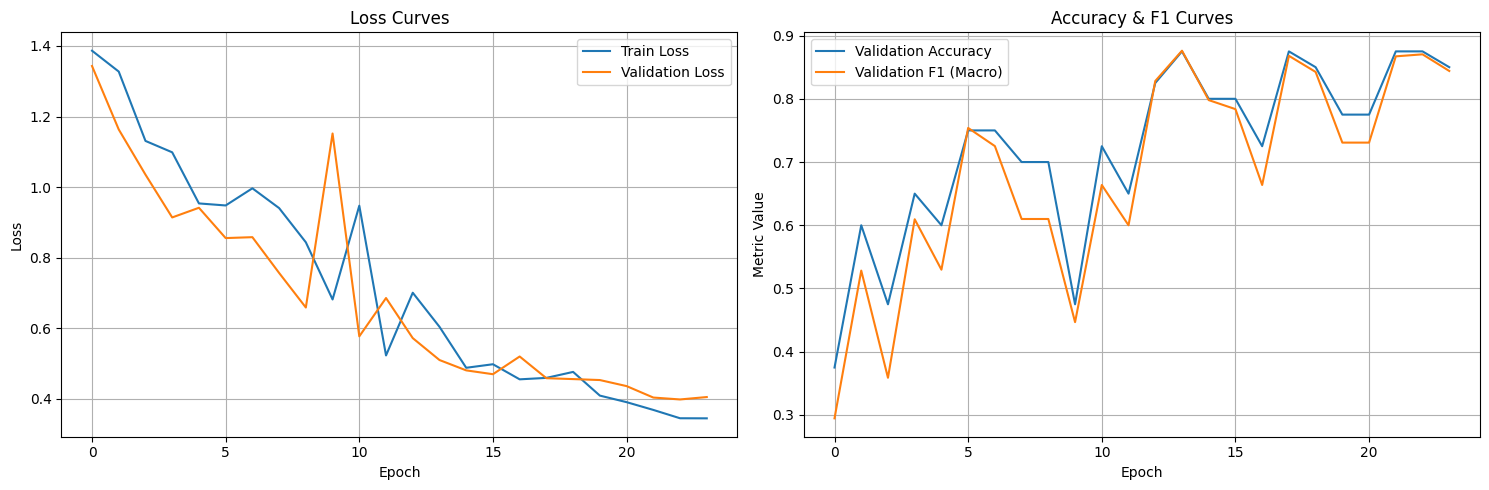

Exception ignored in: <function KeypointSequenceDataset.__del__ at 0x000001C806809D30>
Traceback (most recent call last):
  File "C:\Users\FERRA\AppData\Local\Temp\ipykernel_25488\4232473005.py", line 17, in __del__
AttributeError: 'KeypointSequenceDataset' object has no attribute '_h5_file'
Exception ignored in: <function KeypointSequenceDataset.__del__ at 0x000001C806809D30>
Traceback (most recent call last):
  File "C:\Users\FERRA\AppData\Local\Temp\ipykernel_25488\4232473005.py", line 17, in __del__
AttributeError: 'KeypointSequenceDataset' object has no attribute '_h5_file'
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating on Test Set...
Total samples: 199
Train samples: 139
Validation samples: 40
Test samples: 20
Number of classes: 4


c:\Users\FERRA\miniconda3\envs\slr_py39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test Set Metrics: {
  "test_loss": 0.8141762018203735,
  "test_acc": 0.800000011920929,
  "test_f1": 0.7867965698242188
}


Generating Test Predictions:   0%|          | 0/1 [00:00<?, ?it/s]


Classification Report (Test Set):
              precision    recall  f1-score   support

     clavier       1.00      1.00      1.00         5
  disque_dur       0.57      0.80      0.67         5
  ordinateur       0.83      1.00      0.91         5
      souris       1.00      0.40      0.57         5

    accuracy                           0.80        20
   macro avg       0.85      0.80      0.79        20
weighted avg       0.85      0.80      0.79        20


Confusion Matrix (Test Set):


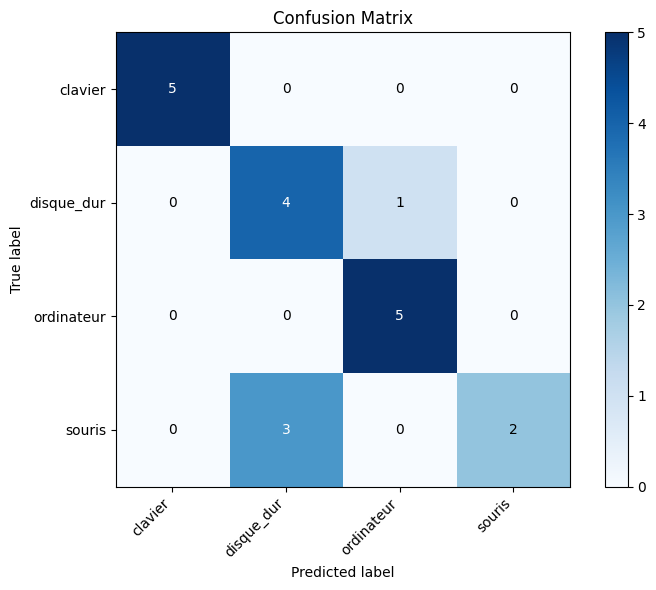

In [13]:
import pandas as pd
def plot_training_curves(log_dir):
    metrics_path = Path(log_dir) / "metrics.csv"
    if not metrics_path.exists():
        print(f"Metrics file not found: {metrics_path}")
        return

    metrics_df = pd.read_csv(metrics_path)
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    if 'train_loss_epoch' in metrics_df.columns:
        plt.plot(metrics_df['epoch'].dropna().unique(), metrics_df.groupby('epoch')['train_loss_epoch'].mean(), label='Train Loss')
    if 'val_loss' in metrics_df.columns:
        plt.plot(metrics_df['epoch'].dropna().unique(), metrics_df.groupby('epoch')['val_loss'].mean(), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    if 'train_acc_epoch' in metrics_df.columns:
         plt.plot(metrics_df['epoch'].dropna().unique(), metrics_df.groupby('epoch')['train_acc_epoch'].mean(), label='Train Accuracy')
    if 'val_acc' in metrics_df.columns:
        plt.plot(metrics_df['epoch'].dropna().unique(), metrics_df.groupby('epoch')['val_acc'].mean(), label='Validation Accuracy')
    if 'val_f1' in metrics_df.columns:
        plt.plot(metrics_df['epoch'].dropna().unique(), metrics_df.groupby('epoch')['val_f1'].mean(), label='Validation F1 (Macro)')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Accuracy & F1 Curves')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def display_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(max(8, len(class_names)), max(6, len(class_names))))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

if trainer and data_module:
    best_model_path = trainer.checkpoint_callback.best_model_path
    if best_model_path and Path(best_model_path).exists():
        print(f"\nLoading best model from: {best_model_path}")
        trained_model = LSTMClassifier.load_from_checkpoint(best_model_path)
        trained_model.eval()
        
        if hasattr(trainer.logger, 'log_dir'):
            plot_training_curves(trainer.logger.log_dir)
        else:
            print("Logger log_dir not found, cannot plot curves automatically.")

        print("\nEvaluating on Test Set...")
        test_results = trainer.test(model=trained_model, datamodule=data_module, verbose=False)
        if test_results:
             print("Test Set Metrics:", json.dumps(test_results[0], indent=2))

        test_loader = data_module.test_dataloader()
        if test_loader:
            all_preds = []
            all_targets = []
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            trained_model.to(device)

            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Generating Test Predictions"):
                    x, y_true = batch
                    x = x.to(device)
                    logits = trained_model(x)
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                    all_preds.extend(preds)
                    all_targets.extend(y_true.cpu().numpy())
            
            if all_targets and all_preds:
                class_names_eval = [data_module.inv_label_map[i] for i in range(data_module.num_classes)]
                print("\nClassification Report (Test Set):")
                print(classification_report(all_targets, all_preds, target_names=class_names_eval, zero_division=0))
                
                print("\nConfusion Matrix (Test Set):")
                display_confusion_matrix(all_targets, all_preds, class_names_eval)
            else:
                print("No predictions or targets from test set to display report/matrix.")
        else:
            print("Test loader not available.")
    else:
        print("Best model path not found. Skipping detailed evaluation.")
        trained_model = None
else:
    print("Trainer or DataModule not available. Skipping evaluation.")
    trained_model = None

### Inference on a New Video


--- Inference on a Sample Video ---
Running inference on: SignLanguageDataset\souris\souris46.mp4

Predicted Class: souris (Confidence: 0.90)

Displaying first few annotated frames from inference video:



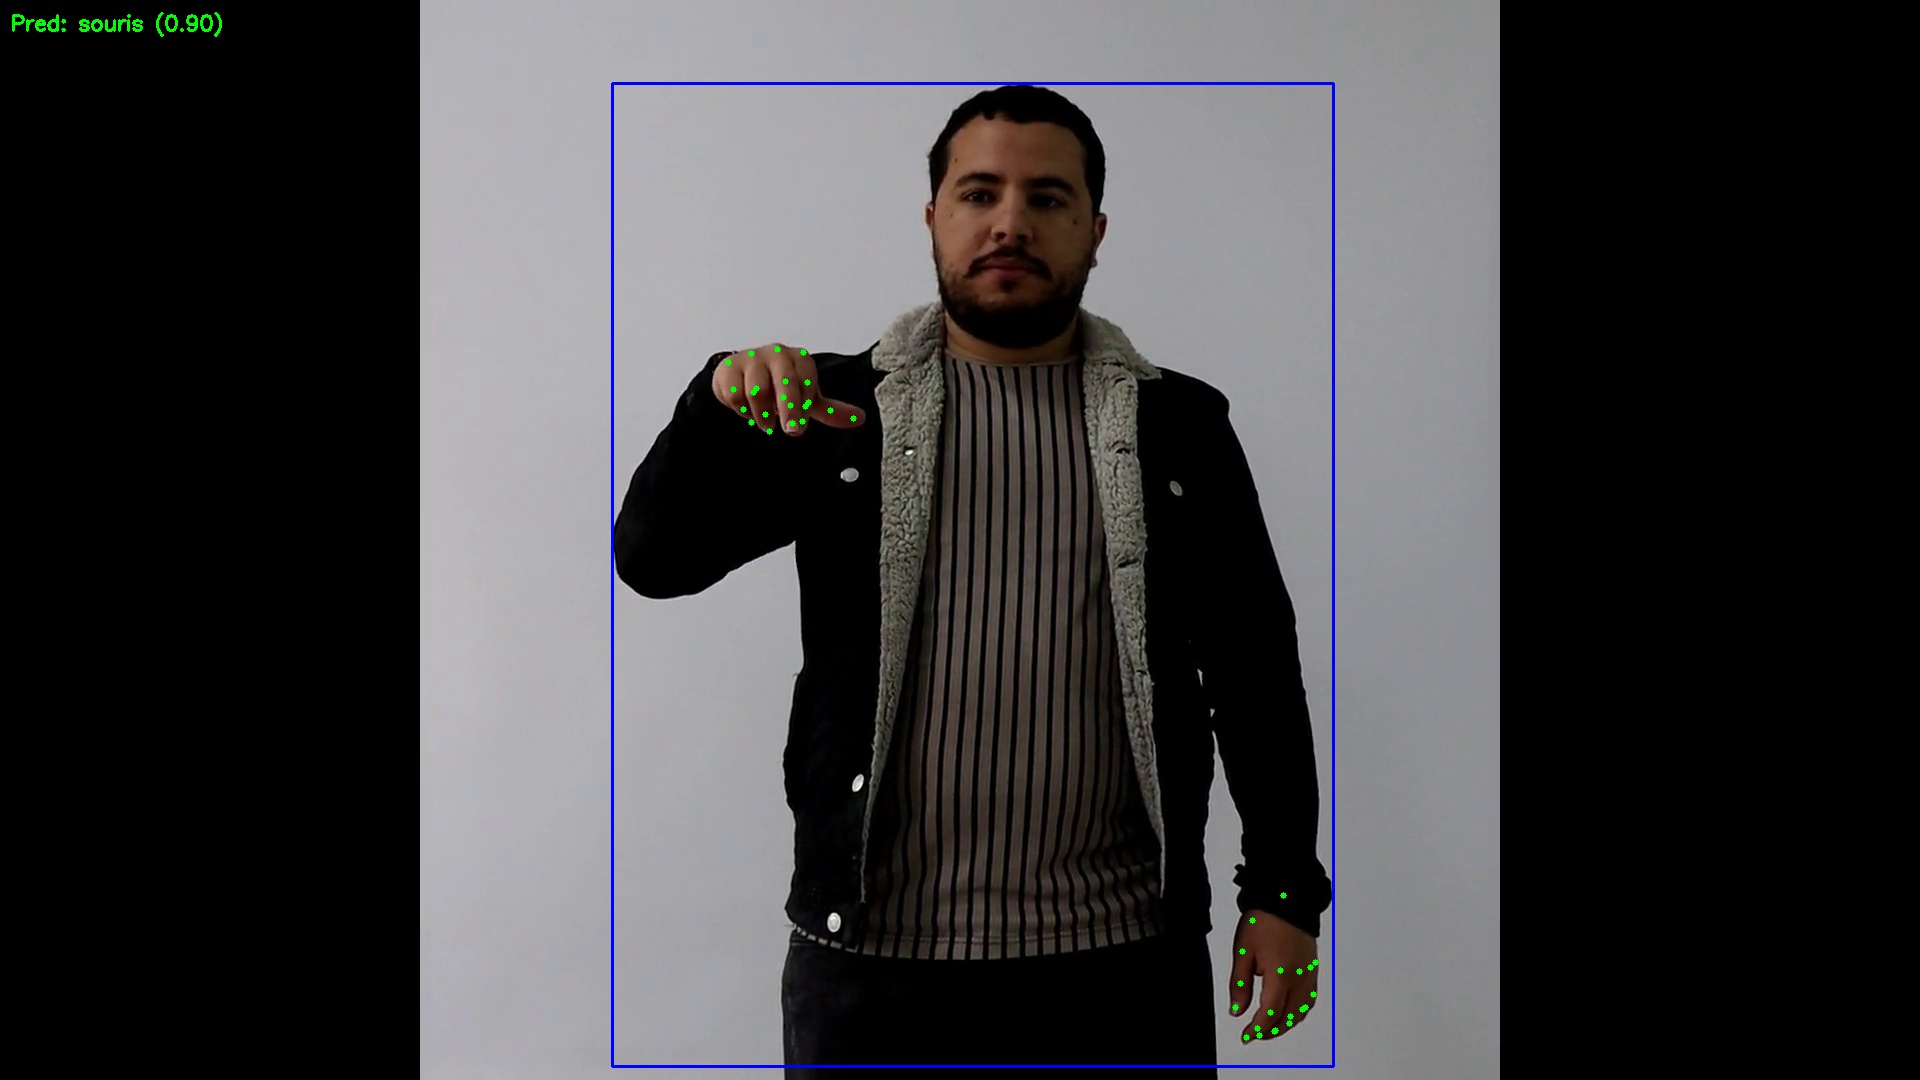

In [17]:
if trained_model and data_module and (yolo_detector is not None or True): # True allows running even if yolo failed to load for full frame mp
    print("\n--- Inference on a Sample Video ---")

    all_videos_for_inference = list(RAW_VIDEO_DATA_DIR.glob("**/*.mp4"))
    if not all_videos_for_inference:
        print("No videos found for inference demo.")
    else:
        inference_video_path = random.choice(all_videos_for_inference)
        print(f"Running inference on: {inference_video_path}")

        cap = cv2.VideoCapture(str(inference_video_path))
        if not cap.isOpened():
            print(f"Error: Could not open video {inference_video_path}")
        else:
            video_keypoints_list_inf = []
            processed_frames_for_display = []

            with mp_hands.Hands(
                    static_image_mode=False, max_num_hands=MAX_NUM_HANDS_MEDIAPIPE,
                    min_detection_confidence=MIN_DETECTION_CONF_MEDIAPIPE,
                    min_tracking_confidence=MIN_TRACKING_CONF_MEDIAPIPE) as hands_solution_inf:
                
                frame_idx = 0
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    
                    keypoints_single_frame_inf, frame_annotated_inf = process_frame_for_keypoints(
                        frame, hands_solution_inf, yolo_detector
                    )
                    video_keypoints_list_inf.append(keypoints_single_frame_inf)
                    processed_frames_for_display.append(frame_annotated_inf)
                    frame_idx +=1

            cap.release()

            if not video_keypoints_list_inf:
                print("No keypoints extracted from the inference video.")
            else:
                video_keypoints_np_inf = np.array(video_keypoints_list_inf, dtype=np.float32)
                current_num_frames_inf = video_keypoints_np_inf.shape[0]
                processed_sequence_inf = None

                if current_num_frames_inf > NUM_FRAMES_PER_VIDEO:
                    start_inf = (current_num_frames_inf - NUM_FRAMES_PER_VIDEO) // 2
                    processed_sequence_inf = video_keypoints_np_inf[start_inf : start_inf + NUM_FRAMES_PER_VIDEO]
                    processed_frames_for_display = processed_frames_for_display[start_inf : start_inf + NUM_FRAMES_PER_VIDEO]
                elif current_num_frames_inf < NUM_FRAMES_PER_VIDEO:
                    padding_frames_inf = NUM_FRAMES_PER_VIDEO - current_num_frames_inf
                    padding_inf = np.zeros((padding_frames_inf, INPUT_SIZE), dtype=np.float32)
                    processed_sequence_inf = np.concatenate((video_keypoints_np_inf, padding_inf), axis=0)
                else:
                    processed_sequence_inf = video_keypoints_np_inf

                if processed_sequence_inf is not None:
                    sequence_tensor_inf = torch.from_numpy(processed_sequence_inf).float().unsqueeze(0)
                    device_inf = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    trained_model.to(device_inf)
                    trained_model.eval()
                    sequence_tensor_inf = sequence_tensor_inf.to(device_inf)

                    with torch.no_grad():
                        logits_inf = trained_model(sequence_tensor_inf)
                        probabilities_inf = torch.softmax(logits_inf, dim=1)
                        confidence_inf, predicted_idx_inf = torch.max(probabilities_inf, dim=1)
                        predicted_class_idx = predicted_idx_inf.item()
                        prediction_confidence = confidence_inf.item()
                        predicted_class_name_inf = data_module.inv_label_map.get(predicted_class_idx, "Unknown")

                    print(f"\nPredicted Class: {predicted_class_name_inf} (Confidence: {prediction_confidence:.2f})")

                    if processed_frames_for_display:
                        output_html_frames = []
                        for display_frame in processed_frames_for_display:
                            cv2.putText(display_frame, f"Pred: {predicted_class_name_inf} ({prediction_confidence:.2f})",
                                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                            _, buffer = cv2.imencode('.jpg', display_frame)
                            img_str = buffer.tobytes()
                            import base64
                            img_base64 = base64.b64encode(img_str).decode('utf-8')
                            output_html_frames.append(f'<img src="data:image/jpeg;base64,{img_base64}" style="width:320px; margin:2px; border:1px solid #ccc;" />')
                        
                        print("\nDisplaying first few annotated frames from inference video:")
                        html_content = f"""
                        <p>Video: {inference_video_path.name} -> Predicted: <strong>{predicted_class_name_inf}</strong></p>
                        <div style="display: flex; flex-wrap: wrap; justify-content: flex-start;">
                            {''.join(output_html_frames[:1])} 
                        </div>
                        """ 
                        if len(output_html_frames) > 15 : html_content += "<p>... and more frames.</p>"
                        display(HTML(html_content))
else:
    print("Trained model, DataModule, or YOLO detector not available. Skipping inference.")

In [15]:
print("\nNotebook execution finished.")


Notebook execution finished.
